<a href="https://colab.research.google.com/github/KonstantinaT/Predictor/blob/main/Encoder_repres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Encoder self-attention using ProTrans pre-trained representations

###Libraries

In [1]:
!pip install transformers
import pandas as pd
import torch
from tqdm import tqdm
import csv
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import plotly
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from numpy import savez_compressed
pd.set_option("display.max_rows", None, "display.max_columns", None)
!pip install -q SentencePiece transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, T5EncoderModel, T5Tokenizer
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
import requests
from sklearn.model_selection import KFold
from torch.autograd import Variable
from sklearn import metrics
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
import re
import os
!pip install Biopython
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import pickle
import math
import gc
import warnings
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from numpy import asarray
from Bio.Seq import Seq
from transformers import AdamW
from torch.optim import Adam
from transformers import T5EncoderModel, T5Tokenizer
from Bio import SeqIO

     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
     |████████████████████████████████| 895 kB 65.1 MB/s 
     |████████████████████████████████| 6.5 MB 61.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 7.1 MB/s 
     |████████████████████████████████| 2.3 MB 8.0 MB/s 


### Dataset

In [2]:
Tier1_2_3 =pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/Tier1_2_3_Other_balance_crop.csv')

In [3]:
Tier1_2_3 = Tier1_2_3.sample(frac = 1) # shuffle datset

In [4]:
Tier1_2_3.head()

,GENE_NAME,ACCESSION_NUMBER,position,AA_orig,AA_targ,sequence,label
16069,CBL,ENST00000264033.4,417,P,A,MAGNVKKSSGAGGGSGSGGSGSGGLIGLMKDAFQPHHHHHHHLSPH...,1
16271,PTPRB,ENST00000334414.6,1170,Q,*,MEAEFYMVILTCLIFRNSEGFQIVHVQKQQCLFKNEKVVVGSCNRT...,1
10530,SMARCB1,ENST00000263121.7,280,E,*,MMMMALSKTFGQKPVKFQLEDDGEFYMIGSEVGNYLRMFRGSLYKR...,1
24409,EZH2,ENST00000320356.2,633,I,M,MGQTGKKSEKGPVCWRKRVKSEYMRLRQLKRFRRADEVKSMFSSNR...,0
34072,PBRM1,ENST00000394830.3,762,D,N,MGSKRRRATSPSSSVSGDFDDGHHSVSTPGPSRKRRRLSNLPTVDP...,0


In [5]:
alpha_label, seq_spaced = [], []
for i, mut in Tier1_2_3.iterrows():
  if mut['label'] == 1:
    alpha_label.append('pathogenic')
  else:
    alpha_label.append('benign')
  temp = " ".join(mut['sequence'])
  seq_spaced.append(temp)

In [6]:
Tier1_2_3 = Tier1_2_3.drop(columns=['label'])

In [7]:
Tier1_2_3.head()

,GENE_NAME,ACCESSION_NUMBER,position,AA_orig,AA_targ,sequence
16069,CBL,ENST00000264033.4,417,P,A,MAGNVKKSSGAGGGSGSGGSGSGGLIGLMKDAFQPHHHHHHHLSPH...
16271,PTPRB,ENST00000334414.6,1170,Q,*,MEAEFYMVILTCLIFRNSEGFQIVHVQKQQCLFKNEKVVVGSCNRT...
10530,SMARCB1,ENST00000263121.7,280,E,*,MMMMALSKTFGQKPVKFQLEDDGEFYMIGSEVGNYLRMFRGSLYKR...
24409,EZH2,ENST00000320356.2,633,I,M,MGQTGKKSEKGPVCWRKRVKSEYMRLRQLKRFRRADEVKSMFSSNR...
34072,PBRM1,ENST00000394830.3,762,D,N,MGSKRRRATSPSSSVSGDFDDGHHSVSTPGPSRKRRRLSNLPTVDP...


In [8]:
Tier1_2_3['label'] = alpha_label
Tier1_2_3['sequence_spaced'] = seq_spaced

In [9]:
labels = {'benign':0,
          'pathogenic':1
          }

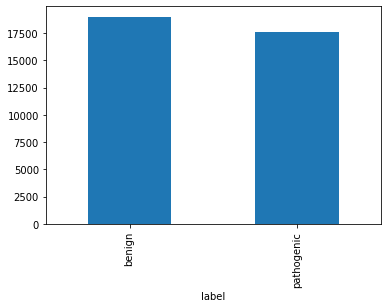

In [10]:
Tier1_2_3.groupby(['label']).size().plot.bar()

### Tokenizer

In [11]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

### Models

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        self.device = 'cuda:0'

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False).to(self.device)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False).to(self.device)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False).to(self.device)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size).to(self.device)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        #print('query len:', query_len)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim).to(self.device)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim).to(self.device)
        query = query.reshape(N, query_len, self.heads, self.head_dim).to(self.device)

        #values = values.reshape(N, value_len, self.heads, self.head_dim)
        #keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        #query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        #print('\n len energy:', len(energy))
        #print('energy shape:', energy.shape)
        #print('values shape:', values.shape)
        mask = mask.unsqueeze(1)
        #print('mask shape:', mask.shape)
        
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        # print('SelfAtt out shape', out.shape)

        return out

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads).to(device)
        self.norm1 = nn.LayerNorm(embed_size).to(device)
        self.norm2 = nn.LayerNorm(embed_size).to(device)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        ).to(device)

        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, value, key, query, mask):
        #print('\nvalue, key, query, mask: ', value, key, query, mask)
        attention = self.attention(value, key, query, mask).to(device)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):

    def __init__(
        self,
        src_vocab_size,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cuda:0",
        max_length=1500,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        
        self.protxl = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to(self.device)
        self.protxl.eval()
        self.position_embedding = nn.Embedding(max_length, self.embed_size).to(self.device)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_id, mask):
        
        print(len(input_id), len(mask))

        gc.collect()
        with torch.no_grad():
            self.word_embedding =  self.protxl(input_ids=input_id,attention_mask=mask)[0]
        
        #print('\n len word embedding :', len(self.word_embedding))
        #print('\n word embedding len(0):', len(self.word_embedding[0]))
        #print('\n word embedding 1st word, 1st sentence len(0)(0):', self.word_embedding[0][0])
        #print('\n word embedding 1st word, 2nd sentence len(1)(0):', self.word_embedding[1][0])

        N, seq_length = input_id.shape
        #print('input_ids shape ', input_id.shape)
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

        #positions = torch.arange(0, seq_length).expand(N, seq_length)
        #print('\n positions:', len(positions))
        #print('\n positions len(0):', len(positions[0]))
        #print(positions)
        print(self.position_embedding(positions))

        out = self.dropout(
            (self.word_embedding + self.position_embedding(positions))
        )
        
        out = out.to(self.device)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)
        #print('Encoder out: ', out)
        return out

In [14]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(512, 2)
        self.vocab_transform = nn.Linear(1024, 1024)
        self.relu = nn.ReLU()
        self.encoder_ins = Encoder(20, embed_size=512, num_layers=6,forward_expansion=4, heads=8, dropout=0, device="cuda:0",max_length=1500)
      
    def forward(self, input_id, mask):
        #print('input_id ', input_id)

        #encoder_ins = Encoder(20, embed_size=1024, num_layers=6,forward_expansion=4, heads=8, dropout=0, device="cuda:0",max_length=2000)
        #whatsthat, pooled_output = encoder_ins(input_id, mask) 
        output_encoder = self.encoder_ins(input_id, mask)  # (bs, seq_length, dim)
        #print('\n output_encoder shape: ', output_encoder.shape)
        #print('\n pooled_output shape: ', pooled_output.shape)
        #hidden_states = whatsthat[:,0]  # (bs, dim)
        #print('hidden_states shape ', hidden_states.shape)   
        hidden_states = output_encoder[:,0]  # (bs, dim)
        #prediction_logits = self.vocab_transform(hidden_states)  # (bs, dim)
        #dropout_output = self.dropout(prediction_logits)# (bs, dim)
        dropout_output = self.dropout(hidden_states)
        linear_output = self.linear(dropout_output)# (bs, 2)
        #print('linear_output shape ', linear_output.shape)
        final_layer = self.relu(linear_output) # (bs, 2)
        #print('final_layer shape ', final_layer.shape)
               
        return final_layer

### Train

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 1500, truncation=True,
                                return_tensors="pt") for text in df['sequence_spaced']]

        #text = list(train_data['sequence_spaced'])
        #self.texts = [tokenizer.batch_encode_plus(text, padding="longest")]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [16]:
def train(model, train_data, val_data, learning_rate, epochs):

    #print('\n Train data', train_data)

    train, val = Dataset(train_data), Dataset(val_data)
    #print('\n Len train:', len(train))
    #print('\n train texts:', train.texts)
    #print('\n train labels:', train.labels)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)

    
    print('\n train device:', device)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                print('\n next batch: \n')

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                #print(input_id)

                #print('embeding_test shape', embeding_test.shape)
                #print('embeding_test[0][3]', embeding_test[0][3])
                #print('embeding_test]1[3] ', embeding_test[1][3])
                 
                output = model(input_id, mask)
                #print('Output shape:', output.size())
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

                       
            total_acc_val = 0
            total_loss_val = 0
            
            '''
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

            '''
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f}')

In [17]:
np.random.seed(112)
df_train, df_val, df_test = np.split(Tier1_2_3.sample(frac=1, random_state=42), 
                                     [int(.8*len(Tier1_2_3)), int(.9*len(Tier1_2_3))])

print(len(df_train),len(df_val), len(df_test))
EPOCHS = 1
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
LR = 1e-6

model = BertClassifier().to(device)

#train(model, Tier1_2_3.head(4),  Tier1_2_3.tail(4), LR, EPOCHS)
              
train(model, df_train, df_val, LR, EPOCHS)
#evaluate(model, df_test)

29308 3663 3664


Downloading:   0%|          | 0.00/10.5G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.4.layer.1.EncDecAttention.q.weight', 'decoder.block.11.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.18.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.1.layer_norm.weight', 'decoder.block.4.layer.2.DenseReluDense.wo.weight', 'decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.8.layer.1.EncDecAttention.k.weight', 'decoder.block.22.layer.2.layer_norm.weight', 'decoder.block.16.layer.1.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.20.layer.1.EncDecAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.16.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.0.SelfAttention.k.weight', 'decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.22.layer.2.Dens


 train device: cuda:0


  0%|          | 0/7327 [00:00<?, ?it/s]


 next batch: 

4 4


  0%|          | 0/7327 [00:03<?, ?it/s]

tensor([[[-0.8740,  0.6329, -0.1235,  ...,  1.4177,  0.8890,  1.9400],
         [-1.7930,  1.0368, -0.5679,  ...,  1.3976, -0.3580, -0.6658],
         [-0.3161, -0.3951,  1.8276,  ..., -0.4268, -1.0835, -0.6571],
         ...,
         [-0.1559, -0.1620, -1.1909,  ...,  2.3004, -0.0875, -0.0881],
         [-0.3874, -1.1034,  0.8544,  ..., -1.0115,  1.7718, -0.9547],
         [-0.2843, -0.2242,  0.1566,  ..., -0.3767,  0.6885, -0.5905]],

        [[-0.8740,  0.6329, -0.1235,  ...,  1.4177,  0.8890,  1.9400],
         [-1.7930,  1.0368, -0.5679,  ...,  1.3976, -0.3580, -0.6658],
         [-0.3161, -0.3951,  1.8276,  ..., -0.4268, -1.0835, -0.6571],
         ...,
         [-0.1559, -0.1620, -1.1909,  ...,  2.3004, -0.0875, -0.0881],
         [-0.3874, -1.1034,  0.8544,  ..., -1.0115,  1.7718, -0.9547],
         [-0.2843, -0.2242,  0.1566,  ..., -0.3767,  0.6885, -0.5905]],

        [[-0.8740,  0.6329, -0.1235,  ...,  1.4177,  0.8890,  1.9400],
         [-1.7930,  1.0368, -0.5679,  ...,  1

RuntimeError: ignored

In [ ]:
# THIS WORKS!
train_data = Tier1_2_3.head(4)
train_input = Dataset(train_data)

mask =  torch.tensor(train_input[0][0]['attention_mask']).to('cuda:0')
input_id =  torch.tensor(train_input[0][0]['input_ids']).to('cuda:0')

test_model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to('cuda:0')

with torch.no_grad():
  embeding_test = test_model(input_ids=input_id,attention_mask=mask)[0]

print('embeding_test shape', embeding_test.shape)
print('embeding_test[0][3]', embeding_test[0][3])
print('embeding_test]1[3] ', embeding_test[1][3])

In [ ]:
# THIS WORKS
test_model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to('cuda:0')
train_data = Tier1_2_3.head(4)
sequences_Example = list(train_data['sequence_spaced'])

gc.collect()
example_ids = tokenizer.batch_encode_plus(sequences_Example, padding="longest") # The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
example_input_ids = torch.tensor(example_ids['input_ids']).to('cuda:0')
example_attention_mask = torch.tensor(example_ids['attention_mask']).to('cuda:0')

with torch.no_grad():
    example_embedding = test_model(input_ids=example_input_ids,attention_mask=example_attention_mask)[0]
example_embedding = example_embedding.cpu().numpy()
print(example_embedding.shape)

(4, 1409, 1024)


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')